<a href="https://colab.research.google.com/github/kiranksnet/kiran/blob/master/Kiran_Final_Project_Assign_numbayes_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMPSCIX433.3-010 - Kiran Khanderao - final Project

***Developing a Training Model to predict image classification using Naiive Bayes***

In [0]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

#NOTE:upload train.csv first!!!

#number of pixels in each dimension of image
IMG_SIZE = 28

# Modeling (Based on Naiive Bayes)

In [0]:
#image class
class Image:
  def __init__(self, vect, actual_class):
    self.data = vect
    self.actual_class = actual_class

#model probabilities class
class Model:
  def __init__(self, p_foreground, p_background, class_num, prob):
    self.p_foreground = p_foreground
    self.p_background = p_background
    self.class_num = class_num
    self.prob = prob


#creates model for certain digit class using list of training images and 
#naive bayes calculations 
#creates foreground and background probability models for each pixel
def create_model_class(k, train_images, class_desired):
  #2d arr
  p_foreground = np.empty([IMG_SIZE, IMG_SIZE])
  p_background = np.empty([IMG_SIZE, IMG_SIZE])
  class_count = 0
  num_images = len(train_images)

  for image in train_images:
    for row in range(0, IMG_SIZE):
      for col in range(0, IMG_SIZE):
        if(image.actual_class == class_desired):
          if image.data[row][col] >0:
            p_foreground[row][col] +=1
          else:
            p_background[row][col] +=1 
          class_count +=1

  for row in range(0, IMG_SIZE):
      for col in range(0, IMG_SIZE):
        fore_count = k + p_foreground[row][col]
        back_count = k + p_background[row][col]
        
        p_foreground[row][col] = fore_count/((2.0*k) + class_count)
        p_background[row][col] = back_count/((2.0*k) + class_count)


  current = Model(p_foreground, p_background, class_desired, class_count*1.0/num_images)
  return current;


#finds the probability distribution of each digit in the given data set
def prob_of_classes(img_list):
  class_probs = np.empty(10)
  num_images = len(img_list)
  
  img_nums=np.array([img.actual_class for img in img_list])

  #scipy usage
  class_probs = stats.binned_statistic(img_nums, np.arange(0,10), statistic='count', bins=10)[0]
  return class_probs

#gets posterior probability for each possible value of given image
#uses model for each digit and finds degree of similarity using summation
#equations in naive bayes theorem
def get_posterior_probs(image, model_list):
  posterior_probs = np.empty(10)
  
  for class_num in range(0, 10):
    model = model_list[class_num]
    posterior_of_class = np.log(model.prob)

    for row in range(0, IMG_SIZE):
      for col in range(0, IMG_SIZE):
        if image.data[row][col] > 0.0:
          posterior_of_class += np.log(model.p_foreground[row][col])
        else:
          posterior_of_class += np.log(model.p_background[row][col])
    
    posterior_probs[class_num] = posterior_of_class
  return posterior_probs

In [11]:

#TRAINING AND CLASSIFICATION PORTION
#k laplace constant
k_const = 0.001

#use training data set and load using pandas
training_imgs = pd.read_csv('train.csv')

num_imgs = len(training_imgs)
training_img_list = []
#partitioning training set to use part as testing
#can possibly help for implementing cross validation techniques later
partition = 1000
for i in range(0, partition):
  img_data = training_imgs.iloc[i]
  img_label = img_data['label']
  img_arr = np.reshape(np.array(img_data[1:]),[IMG_SIZE, IMG_SIZE]) 
  training_img_list.append(Image(img_arr, img_label))

#create models for each possible digit value using all of training data
model_list = []
for i in range(0, 10):
  curr_model = create_model_class(k_const, training_img_list, i)
  model_list.append(curr_model)

#classification

#create list of testing images from original dataset
testing_img_list = []
for i in range(partition, partition*2):
  img_data = training_imgs.iloc[i]
  img_label = img_data['label']
  img_arr = np.reshape(np.array(img_data[1:]),[IMG_SIZE, IMG_SIZE]) 
  testing_img_list.append(Image(img_arr, img_label))

#variables to hold return values of classification
correctly_classified = 0
prob_classes = prob_of_classes(testing_img_list)
num_test_imgs = len(testing_img_list)

original = []
classifications = []
accuracy_per_class = np.empty(10)

#find posterior probabilities for each image and chose 
#the class with the biggest probability value for that image as
#classified value
#keep track of expected vs actual for accuracy testing
for i in range(0, num_test_imgs):
  posterior_probs = get_posterior_probs(testing_img_list[i], model_list)
  class_predicted = np.argmax(posterior_probs)
  classifications.append(class_predicted)

  if(testing_img_list[i].actual_class == class_predicted):
    correctly_classified+=1
    accuracy_per_class[class_predicted] += 1
  original.append(testing_img_list[i].actual_class)

accuracy_per_class = accuracy_per_class / (prob_classes) /partition
print('accuracy = ', correctly_classified*1.0/num_test_imgs)



accuracy =  0.824


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.


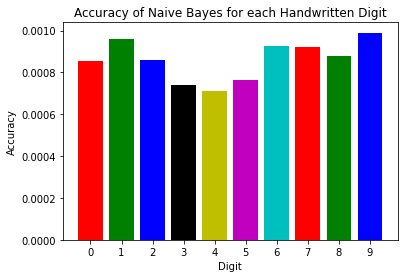

In [12]:
#plot accuracy for each digit
my_colors = 'rgbkymc'
X_vals = np.arange(0, 10)

plt.bar(X_vals, accuracy_per_class, color=my_colors)
plt.xlabel('Digit')
plt.ylabel('Accuracy')

plt.xticks(X_vals)
plt.title('Accuracy of Naive Bayes for each Handwritten Digit')
plt.show()

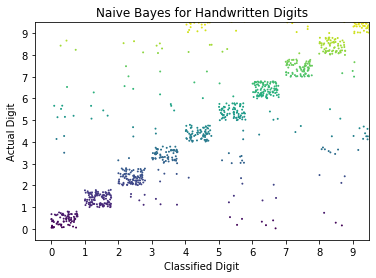

In [13]:

#Plot actual vs classified values
graphical_offsets = np.random.uniform(low=0.0, high=0.8, size=(partition,))
graphical_offsets2 = np.random.uniform(low=0.0, high=0.8, size=(partition,))

X = classifications + graphical_offsets
Y = original + graphical_offsets2
plt.scatter(Y, X, c=X, s=0.9);

X_vals = np.arange(0, 10)
plt.axis([-.5, 9.5, -.5, 9.5] )
plt.xticks(X_vals)
plt.yticks(X_vals)

plt.title('Naive Bayes for Handwritten Digits')
plt.xlabel('Classified Digit')
plt.ylabel('Actual Digit')
plt.show()


In [14]:
#analyze actual vs classified data sets
stats.ttest_ind(classifications, original)

Ttest_indResult(statistic=0.5634692448085967, pvalue=0.5731786272136252)

In [15]:
#how normal original vs actual distribution is
z_val_classification, p_val_classification = stats.normaltest(classifications)
z_val_original, p_val_original = stats.normaltest(original)

print('z val for classification =', z_val_classification,' p val for classification = ', p_val_classification)

print('z val for original data =', z_val_original, 'p val for original data =', p_val_original)


z val for classification = 1498.5823823869089  p val for classification =  0.0
z val for original data = 972.5661385652122 p val for original data = 6.455745000550415e-212


Text(0.5, 1.0, 'Expected probability distribution')

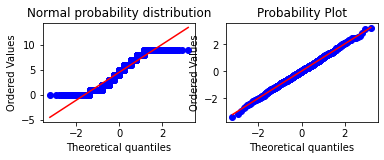

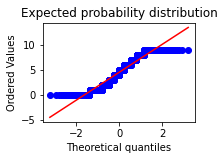

In [16]:
#classified values probability distribution
fig = plt.figure()
ax = fig.add_subplot(221)
res = stats.probplot(classifications, plot=ax)
ax.set_title('Classifications probability distribution')

#normal distribution results
ax2 = fig.add_subplot(222)
x = stats.norm.rvs(loc=0, scale=1, size=partition)
res = stats.probplot(x, plot=ax2)
ax.set_title('Normal probability distribution')

#actual values probability distribution
fig = plt.figure()
ax = fig.add_subplot(223)
res = stats.probplot(classifications, plot=ax)
ax.set_title('Expected probability distribution')